# **Imports**

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from google.colab import files
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# **Introduction and Background**

**Problem Statement:**

The taxi industry in New York City faces challenges in optimizing fare pricing, understanding customer behavior, and predicting demand. Factors like time of day, location, trip distance, and external events significantly impact fare amounts and driver earnings. There is a need to better analyze these factors to gain insights into trends and optimize operations.

**Objective:**

The objective of this project is to analyze the NYC Taxi Fare dataset to:

1. **Identify key factors influencing taxi fares.** This involves exploring relationships between fare amounts, tip amounts, trip distance, time of day, pick-up and drop-off locations, and other relevant features.
2. **Develop a model to predict taxi fares based on these key factors.** A predictive model can help drivers estimate potential earnings for a trip or help taxi riders estimate the potential total cost for a taxi ride, allowing them to make more informed decisions.
3. **Discover actionable insights to improve the taxi service experience.** Through EDA we explore busiest times of day, average total cost on different times of day and analyze which months of the year have highest speeds. These insights can help develop discounts by taxi companies and send precautionary messages to drivers to slow down.
**Value Proposition:**

This project offers several valuable outcomes:

1. **For Taxi Drivers:**
- **Improved Earning Potential**: By accurately predicting fares, drivers can make strategic decisions to maximize their income by focusing on high-demand routes and times.
2. **For Taxi Companies:**
- **Optimized Pricing Strategies**: Insights on fare dynamics allow companies to develop competitive pricing plans, improving profitability and customer satisfaction.
- **Improved Customer Service**: Analyzing factors influencing fares and trip durations can highlight areas for service improvements that increase customer loyalty. Increase safety of taxi drivers and customers by analyzing speeds and busiest times of day.
3. **For Customers:**
- **Predictable and Transparent Fares**: By understanding the factors impacting fares, we aim to enable more accurate fare estimations, reducing surprises and improving budget planning.
- **Fair and Competitive Pricing**: Data-driven analysis helps to ensure fair and competitive pricing models are applied, ensuring riders receive a value-driven experience for every trip.

By leveraging the NYC Taxi Fare data through a model-driven approach, this project provides insights and tools that empower the various stakeholders in the taxi ecosystem to make better, data-informed decisions. This can lead to a more efficient, equitable, and customer-centric taxi service in New York City.

# **Dataset**

### NYC Taxi Fare
https://www.kaggle.com/datasets/diishasiing/revenue-for-cab-drivers

This dataset provides comprehensive trip records of taxi rides, including information such as pickup and drop-off times, passenger count, trip distance, and fare details. It also includes unique identifiers for the pickup and drop-off locations, fare components like tips, tolls, surcharges, and payment types. Additionally, congestion surcharges and the rate code used for the trip are available for analysis.

This Dataset Contains Over 6,400,000 Rows

Taxi Zones Dataset can be Found Here: \\
https://data.cityofnewyork.us/Transportation/NYC-Taxi-Zones/d3c5-ddgc

**Upload the Datasets to Google Colab in the File Icon on the Right First**

In [ ]:
taxi_fare_path = "data.csv"
taxi_zone_path = "taxi_zones.csv"

**Read the Datasets into Dataframes**

In [ ]:
raw_taxi_fare_df = pd.read_csv(taxi_fare_path, low_memory=False)
raw_taxi_zones_df =  pd.read_csv(taxi_zone_path)

# **Data Cleaning and Wrangling**

## Pre-Processing

### Step 1: Select Relevant Columns

In the `taxi_fare` dataset, pick the following columns:

> 'VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge'

### Step 2: Get Names for Locations

The `taxi_fare` dataset only includes standardized IDs for locations, without names. Use the `taxi_zones` dataset to match `PULocationID` in `taxi_fare` with `LocationID` in `taxi_zones`, enabling us to get the names of boroughs and zones corresponding to each location.

- For each PULocationID we add `pick_up_borough` and for DOLocationID we add `drop_of_borough`. We also add `pick_up_zone` and `drop_of_zone` for each.
- Rename columns in the `taxi_fare` dataset for clarity: `"tpep_pickup_datetime"` to `"pick_up_datetime"`, `"tpep_dropoff_datetime"` to `"drop_off_datetime"`, and `"extra"` to `"extra_charges"`.

- Zone and borough together form a composite key for each location.
- We Retain the original `PULocationID` and `DOLocationID` for future modeling since they are numerical and easier to process.

### Step 3: Data Cleaning

- Drop all rows with null values to reduce the dataset size and ensure clean data for analysis.


In [ ]:
# Select the relevant columns from the dataframes
taxi_zones_df = raw_taxi_zones_df[['LocationID', 'borough', 'zone']]
taxi_fare_preprocessed_df = raw_taxi_fare_df[['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge']]

# Merge the two dataframes to get the borough and zone of the Pick Up and Drop Off location from its LocationID for each taxi ride
taxi_fare_preprocessed_df = taxi_fare_preprocessed_df.merge(taxi_zones_df, left_on="PULocationID", right_on="LocationID").rename(columns={"borough": "pick_up_borough", "zone": "pick_up_zone"})
taxi_fare_preprocessed_df = taxi_fare_preprocessed_df.merge(taxi_zones_df, left_on="DOLocationID", right_on="LocationID").rename(columns={"borough": "drop_off_borough", "zone": "drop_off_zone"})

# Drop the LocationID columns from the merged table, but we retain PULocationID and DOLocationID
taxi_fare_preprocessed_df = taxi_fare_preprocessed_df.drop(["LocationID_x", "LocationID_y"], axis=1)

# To decrease the number of rows, drop all rows with null values
taxi_fare_preprocessed_df = taxi_fare_preprocessed_df.dropna()

# rename columns
taxi_fare_preprocessed_df = taxi_fare_preprocessed_df.rename(columns={"tpep_pickup_datetime": "pick_up_datetime", "tpep_dropoff_datetime": "drop_off_datetime", "extra" : "extra_charges"})

raw_num_rows = len(taxi_fare_preprocessed_df)
taxi_fare_preprocessed_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6272438 entries, 0 to 6272437
Data columns (total 20 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   VendorID               float64
 1   pick_up_datetime       object 
 2   drop_off_datetime      object 
 3   passenger_count        float64
 4   trip_distance          float64
 5   PULocationID           int64  
 6   DOLocationID           int64  
 7   payment_type           float64
 8   fare_amount            float64
 9   extra_charges          float64
 10  mta_tax                float64
 11  tip_amount             float64
 12  tolls_amount           float64
 13  improvement_surcharge  float64
 14  total_amount           float64
 15  congestion_surcharge   float64
 16  pick_up_borough        object 
 17  pick_up_zone           object 
 18  drop_off_borough       object 
 19  drop_off_zone          object 
dtypes: float64(12), int64(2), object(6)
memory usage: 1005.0+ MB


## Reducing the DataFrame Further
The Resulting DataFrame from above still has 6,272,437 rows \\
In order to reduce the DataFrame further, we will apply the following filters.

### Retain trips that lasted max 24 hours
Since we are dealing with taxi trips in NYC, trips longer than 24 hours don't make sense. We also see that only 13 of such trips existed thus they were outliers.

In [ ]:
taxi_fare_df = taxi_fare_preprocessed_df.copy()
# Convert the pick_up_datetime and drop_off_datetime columns to datetime format
taxi_fare_df["pick_up_datetime"] = pd.to_datetime(taxi_fare_df["pick_up_datetime"])
taxi_fare_df["drop_off_datetime"] = pd.to_datetime(taxi_fare_df["drop_off_datetime"])

In [ ]:
# Only retain trips with maximum duration of 1 day
taxi_fare_df["num_of_days"] = (taxi_fare_df["drop_off_datetime"] - taxi_fare_df["pick_up_datetime"]).dt.total_seconds() / 3600
taxi_fare_df = taxi_fare_df[taxi_fare_df["num_of_days"] < 24]
taxi_fare_df = taxi_fare_df.drop("num_of_days", axis=1)

num_trips_more_than_24_hours = raw_num_rows - len(taxi_fare_df)

print(f"Number of rows removed: {num_trips_more_than_24_hours}")

Number of rows removed: 13


### Retain records for one year
As we see below, more than 99.99% of the data belongs to year 2020. We will remove records that belong to other years since we don't have enough representation for them.

In [ ]:
# find out which years and how many records per year exist
yearly_trip_counts = taxi_fare_df.groupby(taxi_fare_df["pick_up_datetime"].dt.year).agg(trip_count=("pick_up_datetime", "size")).reset_index()
yearly_trip_counts["trip_count_percentage"] = (yearly_trip_counts["trip_count"] / yearly_trip_counts["trip_count"].sum()) * 100
yearly_trip_counts

,pick_up_datetime,trip_count,trip_count_percentage
0,2003,1,0.000016
1,2008,10,0.000159
2,2009,17,0.000271
3,2019,131,0.002089
4,2020,6272263,99.997417
5,2021,3,0.000048


In [ ]:
# retain only the rows from year 2020
taxi_fare_df = taxi_fare_df[taxi_fare_df["pick_up_datetime"].dt.year == 2020]

### Filter invalid records
we will only retain the records that meet the following conditions
- rows with `trip_distance > 0`
- rows with `passenger_count > 0`
- rows with `total_amount > 0`
- rows with different pick up and drop off times. **Reason:** remove trips with zero duration.

In [ ]:
# Filter rows to only contain different pick up and drop off times
taxi_fare_df = taxi_fare_df[taxi_fare_df["pick_up_datetime"].dt.time != taxi_fare_df["drop_off_datetime"].dt.time]

# Filter rows to only contain rows with trip_distance > 0
taxi_fare_df = taxi_fare_df[taxi_fare_df["trip_distance"] > 0]

# Filter rows to only contain rows with passenger_count > 0
taxi_fare_df = taxi_fare_df[taxi_fare_df["passenger_count"] > 0]

# Filter rows to only contain rows with total_amount > 0
taxi_fare_df = taxi_fare_df[taxi_fare_df["total_amount"] > 0]

In [ ]:
print(f"Number of rows removed: {raw_num_rows - len(taxi_fare_df)}")

Number of rows removed: 182363


### Drop Duplicated rows
Remove any duplicate rows (keep the first occurance only)
Duplicate rows will skew the results.

Also output the number of duplicate rows removed.

If we run cells sequentially, this should output 3422 duplicate rows were removed

In [ ]:
# drop duplicates and count how many duplicates are dropped
# Get the number of rows before dropping duplicates
n_before = len(taxi_fare_df)

# Drop duplicates in place
taxi_fare_df.drop_duplicates(inplace=True)

# Get the number of rows after dropping duplicates
n_after = len(taxi_fare_df)

# Calculate the number of duplicates dropped
n_duplicates_dropped = n_before - n_after

print(f"Number of duplicates dropped: {n_duplicates_dropped}")

Number of duplicates dropped: 3422


## Stratify Random Sample
We perform stratified random sampling on taxi_fare_df using `(PULocationID, DOLocationID)` pairs as strata. By taking a random sample from each group with a consistent fraction, we ensure that each pair retains its original proportion in the sample.

>This creates a smaller, representative dataset that preserves the relative distribution of each pickup-drop-off location pair, giving us a representative sample of each borough in NYC.

In [ ]:
sampled_data_df = taxi_fare_df.groupby(["PULocationID", "DOLocationID"]).sample(frac=0.25, random_state=42)
print(f"Sampled Data has {len(sampled_data_df)} number of rows")

Sampled Data has 1519506 number of rows


### Verify the relative distribution of each borough
We shall now verify that our sampled data has correclty retained the relative proportions of each borough. This will give us confidence that we have a representative sample and we haven't lost diversity in our values.

<Figure size 1000x600 with 0 Axes>

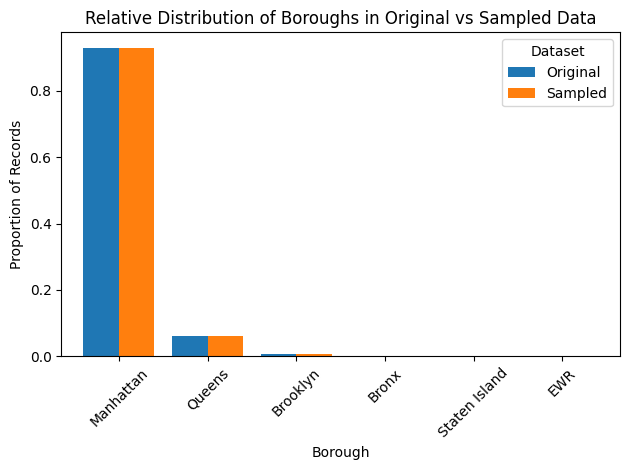

In [ ]:
original_borough_counts = taxi_fare_df['pick_up_borough'].value_counts(normalize=True)
sampled_borough_counts = sampled_data_df['pick_up_borough'].value_counts(normalize=True)

# Combine both distributions into a DataFrame for easy comparison
borough_distribution = pd.DataFrame({
    'Original': original_borough_counts,
    'Sampled': sampled_borough_counts
}).fillna(0)  # Fill NaN with 0 for any missing boroughs

# Plot the distributions
plt.figure(figsize=(10, 6))
borough_distribution.plot(kind='bar', width=0.8)
plt.title('Relative Distribution of Boroughs in Original vs Sampled Data')
plt.xlabel('Borough')
plt.ylabel('Proportion of Records')
plt.xticks(rotation=45)
plt.legend(title='Dataset')
plt.tight_layout()
plt.show()

# **Feature Extraction**

There is potential to extract some very interesting features from our existing data. So let's do that one by one

## Extracting Time of Day

Extract the time of day (Morning, Noon, Afternoon, Evening, Midnight, Night) for both pick-up and drop-off times. We do this for both `sampled_data_df` and `taxi_fare_df` so we can compare the relative distributions of time of the day.

### Step 1: `get_time_of_day` Function

This function takes an hour (as an integer) as input and returns a string representing the time of day based on the following logic:
- 6 to 11: Morning
- 12: Noon
- 13 to 17: Afternoon
- 18 to 20: Evening
- 0: Midnight
- Other hours: Night

### Step 2: Applying the `get_time_of_day` Function

Apply the `get_time_of_day` function directly to the `pick_up_datetime` and `drop_off_datetime` columns.

In [ ]:
# Define the get_time_of_day function
def get_time_of_day(hour):
    if 6 <= hour < 12:
        return "Morning"
    elif hour == 12:
        return "Noon"
    elif 13 <= hour < 18:
        return "Afternoon"
    elif 18 <= hour < 21:
        return "Evening"
    else:
        return "Midnight" if hour == 0 else "Night"

# Apply the get_time_of_day function directly to extract time of day
taxi_fare_df["PU_time_of_day"] = taxi_fare_df["pick_up_datetime"].dt.hour.apply(get_time_of_day)
taxi_fare_df["DO_time_of_day"] = taxi_fare_df["drop_off_datetime"].dt.hour.apply(get_time_of_day)
sampled_data_df["PU_time_of_day"] = sampled_data_df["pick_up_datetime"].dt.hour.apply(get_time_of_day)
sampled_data_df["DO_time_of_day"] = sampled_data_df["drop_off_datetime"].dt.hour.apply(get_time_of_day)

# Display the new columns
# taxi_fare_df[["pick_up_datetime", "PU_time_of_day", "drop_off_datetime", "DO_time_of_day"]].head()
# sampled_data_df[["pick_up_datetime", "PU_time_of_day", "drop_off_datetime", "DO_time_of_day"]].head()

### Verify the day distributions in sampled data
We can verify if relative proportion of trips per time of day has been maintained in our sample data. This will really hone in the point that our sample data is unbiased relative to the original data.

<Figure size 1000x600 with 0 Axes>

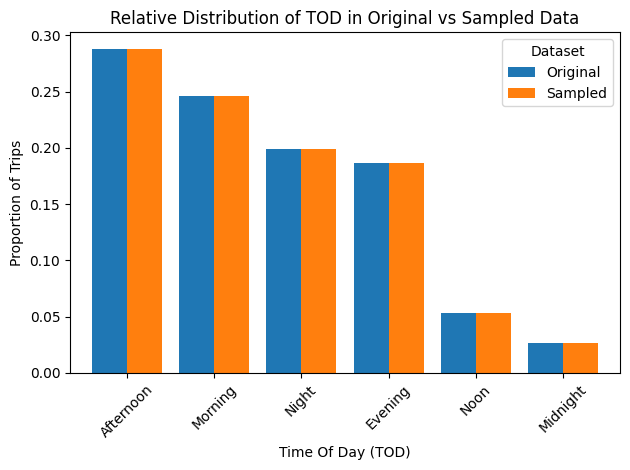

In [ ]:
# Note tod = time of day
original_tod_counts = taxi_fare_df['PU_time_of_day'].value_counts(normalize=True)
sampled_tod_counts = sampled_data_df['PU_time_of_day'].value_counts(normalize=True)

# Combine both distributions into a DataFrame for easy comparison
tod_distribution = pd.DataFrame({
    'Original': original_tod_counts,
    'Sampled': sampled_tod_counts
}).fillna(0)

# Plot the distributions
plt.figure(figsize=(10, 6))
tod_distribution.plot(kind='bar', width=0.8)
plt.title('Relative Distribution of TOD in Original vs Sampled Data')
plt.xlabel('Time Of Day (TOD)')
plt.ylabel('Proportion of Trips')
plt.xticks(rotation=45)
plt.legend(title='Dataset')
plt.tight_layout()
plt.show()

## Extract Price Per Unit Distance
Let's extract 3 additional features that will allow us future analysis.
1. **Base Fare Per Unit Distance**
   - Calculated as: `fare_amount / trip_distance`
   - This feature represents the base fare amount charged per unit distance traveled. It gives us an idea of how the base fare scales with distance and allows us to compare fares across trips of different lengths.

2. **Total Cost Per Unit Distance**
   - Calculated as: `total_amount / trip_distance`
   - This feature calculates the total fare per unit distance, including all extra charges, tips, and surcharges. It provides a holistic view of the total cost incurred by a passenger for each unit of distance traveled.

3. **Tip Per Unit Distance**
   - Calculated as: `tip_amount / trip_distance`
   - This feature represents the tip given per unit distance. It can help analyze tipping patterns relative to trip distance, giving insight into the relationship between distance and tipping behavior.


In [ ]:
# Calculate base fare per unit distance
sampled_data_df["base_fare_per_unit_distance"] = sampled_data_df["fare_amount"] / sampled_data_df["trip_distance"]

# Calculate total cost per unit distance
sampled_data_df["total_cost_per_unit_distance"] = sampled_data_df["total_amount"] / sampled_data_df["trip_distance"]

# Calculate tip per unit distance
sampled_data_df["tip_per_unit_distance"] = sampled_data_df["tip_amount"] / sampled_data_df["trip_distance"]

## Calculating Trip Duration

Calculate the duration of each taxi trip based on the pick-up and drop-off times. For now we calculate the total seconds. But later when we need, we can easily convert total seconds to H:M:S format


In [ ]:
sampled_data_df["trip_duration"] = (sampled_data_df["drop_off_datetime"] - sampled_data_df["pick_up_datetime"]).dt.total_seconds()
sampled_data_df[['drop_off_datetime', 'pick_up_datetime', 'trip_duration']].head()

,drop_off_datetime,pick_up_datetime,trip_duration
4724517,2020-01-24 19:31:25,2020-01-24 19:22:20,545.0
1904628,2020-01-11 06:38:18,2020-01-11 06:36:54,84.0
5896925,2020-01-30 13:33:58,2020-01-30 13:33:37,21.0
429791,2020-01-03 16:55:49,2020-01-03 16:55:44,5.0
4108914,2020-01-22 05:42:26,2020-01-22 05:40:06,140.0


## Calculating Average Trip Speed

Calculate the average speed of each taxi trip based on the trip distance and duration.
**Note** units for Trip Speed = `miles per hour` since trip_distance is miles.

In [ ]:
sampled_data_df["average_speed"] = sampled_data_df["trip_distance"] / (sampled_data_df["trip_duration"]/3600)
sampled_data_df[['trip_distance', 'trip_duration', 'average_speed']].head()

,trip_distance,trip_duration,average_speed
4724517,2.97,545.0,19.618349
1904628,16.70,84.0,715.714286
5896925,0.02,21.0,3.428571
429791,0.02,5.0,14.400000
4108914,4.70,140.0,120.857143


###Remove obviously invalid trips
If you see above, second row has an average_speed of 715.7 miles/hour. This is obviously incorrect measurement and that's visible in the dataframe as well.
> If we take a look at this trip: It has
*   pickup time of 2020-01-11 06:36:54
*   dropoff time of 2020-01-11 06:38:18	(84 seconds duration)

however, in such a short time it has a trip distance of 16.70 miles
thus our code gives a average speed of 715.714286 miles per hour.

We can use these outliers to filter down trips that have incorrectly been measured either by human error or machine error. To get a better sense of our distribution of average speed, let's draw a Box and Whisker Plot below.

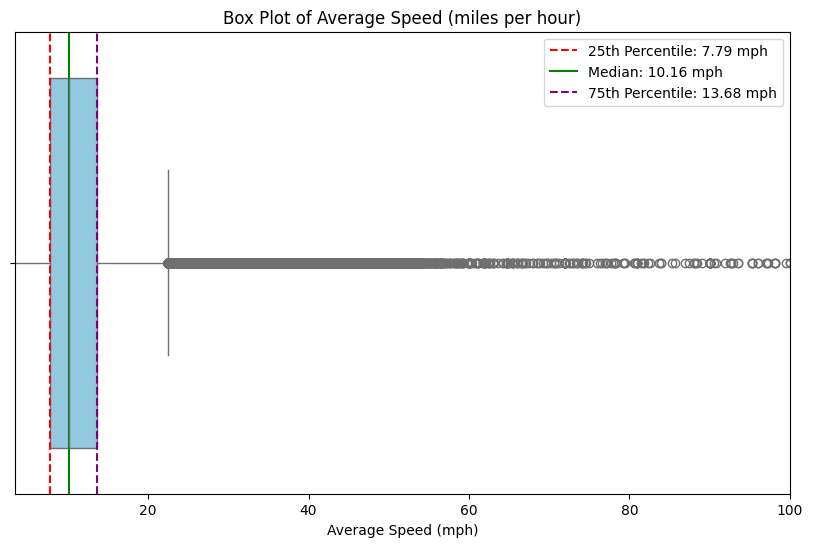

In [ ]:
# Calculate summary statistics
twenty_fifth_speed = sampled_data_df["average_speed"].quantile(0.25)
seventy_fifth_speed = sampled_data_df["average_speed"].quantile(0.75)
median_speed = sampled_data_df["average_speed"].median()

# Determine x-axis lower limit based on percentile
lower_limit = sampled_data_df["average_speed"].quantile(0.01)

# Plot the box plot with x-axis limits
plt.figure(figsize=(10, 6))
sns.boxplot(data=sampled_data_df, x="average_speed", color="skyblue")
plt.xlim(lower_limit, 100)  # Setting the upper limit manually to 100 based on trial and error

# Add markers for 25th percentile, median, and 75th percentile
plt.axvline(twenty_fifth_speed, color='red', linestyle='--', label=f'25th Percentile: {twenty_fifth_speed:.2f} mph')
plt.axvline(median_speed, color='green', linestyle='-', label=f'Median: {median_speed:.2f} mph')
plt.axvline(seventy_fifth_speed, color='purple', linestyle='--', label=f'75th Percentile: {seventy_fifth_speed:.2f} mph')

# Add legend and labels
plt.title("Box Plot of Average Speed (miles per hour)")
plt.xlabel("Average Speed (mph)")
plt.legend()
plt.show()

This shows us that our median speed is rather low, only `10.16` miles per hour. However, this makes total sense based on many articles online including this one: https://nyc.streetsblog.org/2024/07/08/midtown-traffic-slower-than-ever-after-hochuls-congestion-pricing-betrayal

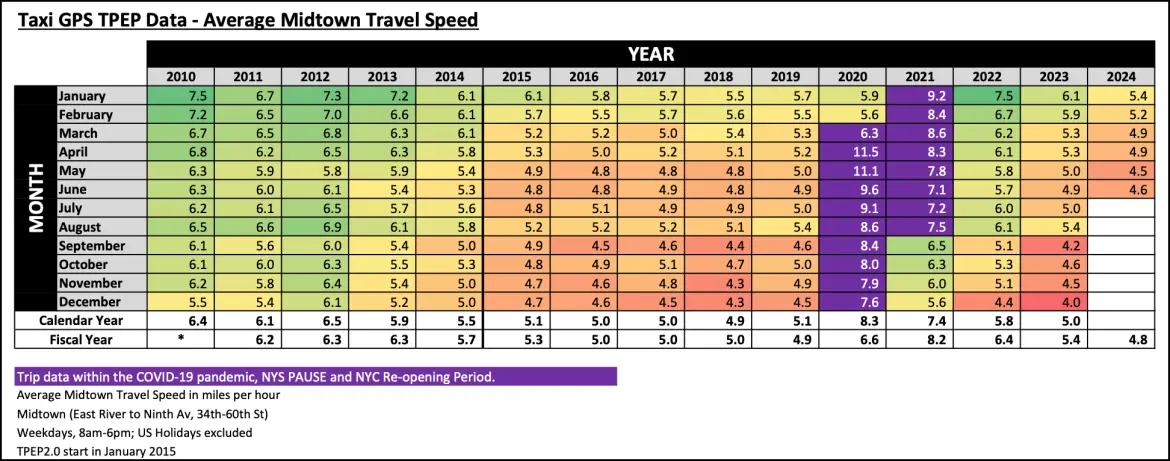
>This graph that shows the average Taxi Speed in New York in 2020. The maximum average speed recorded in 2020 was in May at 11.1 miles per hour.

>Therefore, we will use Interquartile Range (IQR)  to find the threshold for outliers and remove all rows that have an average speed beyond this threshold.

In [ ]:
num_rows_before = len(sampled_data_df)

In [ ]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = sampled_data_df["average_speed"].quantile(0.25)
Q3 = sampled_data_df["average_speed"].quantile(0.75)

# Calculate IQR
IQR = Q3 - Q1

# Define lower and upper bounds for normal speeds
lower_bound = max(0, Q1 - 1.5 * IQR)
# multiply upper bound by 2 instead of 1.5 to relax the filtering criteria
upper_bound = Q3 + 2 * IQR

print(f"Lower bound: {lower_bound}")
print(f"Upper bound: {upper_bound}")

# Filter rows to only include those within the IQR bounds.
filtered_data_df = sampled_data_df[(sampled_data_df["average_speed"] >= lower_bound) &
                                   (sampled_data_df["average_speed"] <= upper_bound)]
filtered_data_df.reset_index(drop=True, inplace=True)

Lower bound: 0
Upper bound: 25.447067357249203


We have filtered out and removed all trips that had a average speed above 25.45 miles/hour and this was being generous with the upper bound to allow for valid outliers.

In [ ]:
print(f"Removed rows = {len(sampled_data_df) - len(filtered_data_df)}")
print(f"Rows remaining = {len(filtered_data_df)}")
print()
filtered_data_df.info()

Removed rows = 69964
Rows remaining = 1449542

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449542 entries, 0 to 1449541
Data columns (total 27 columns):
 #   Column                        Non-Null Count    Dtype         
---  ------                        --------------    -----         
 0   VendorID                      1449542 non-null  float64       
 1   pick_up_datetime              1449542 non-null  datetime64[ns]
 2   drop_off_datetime             1449542 non-null  datetime64[ns]
 3   passenger_count               1449542 non-null  float64       
 4   trip_distance                 1449542 non-null  float64       
 5   PULocationID                  1449542 non-null  int64         
 6   DOLocationID                  1449542 non-null  int64         
 7   payment_type                  1449542 non-null  float64       
 8   fare_amount                   1449542 non-null  float64       
 9   extra_charges                 1449542 non-null  float64       
 10  mta_tax            

## Download the processed df into csv

Since we have cut down the rows quite a bit we should download the updated dataframe into a csv so we can jump back to this step.

In [ ]:
# convert taxi_fare_df into csv and store it so we can jump straight to this step next time
def store_df_into_csv(df, filename):
  df.to_csv(filename, index=False)
  files.download(filename)

# UNCOMMENT THIS TO RUN THIS FUNCTION and download the file locally
# store_df_into_csv(filtered_data_df, "filtered_data.csv")

## Reload the CSV into DF
In order to jump start from this step, we define a function to reload the csv into dataframe.

**Note**: Make sure the file passed into this method exists in the file folder here on Collab.

*   You can upload it if you have it already.
*   Or you can run the cells above and it will download the file for you.

In [ ]:
def load_csv_into_df(filename, dataTypes, datetime_cols):
    return pd.read_csv(
        filename,
        dtype=dataTypes,
        parse_dates=datetime_cols,
        low_memory=False)

# be intentional with these
dtypes = {
    "VendorID": "float64",
    "passenger_count": "float64",
    "trip_distance": "float64",
    "PULocationID": "int64",
    "DOLocationID": "int64",
    "payment_type": "float64",
    "fare_amount": "float64",
    "extra_charges": "float64",
    "mta_tax": "float64",
    "tip_amount": "float64",
    "tolls_amount": "float64",
    "improvement_surcharge": "float64",
    "total_amount": "float64",
    "congestion_surcharge": "float64",
    "pick_up_borough": "object",
    "pick_up_zone": "object",
    "drop_off_borough": "object",
    "drop_off_zone": "object",
    "PU_time_of_day": "object",
    "DO_time_of_day": "object",
    "base_fare_per_unit_distance": "float64",
    "total_cost_per_unit_distance": "float64",
    "tip_per_unit_distance": "float64",
    "trip_duration": "float64",
    "average_speed": "float64"
}

# This is so we can just "Run All" the cells without error
if (os.path.exists("filtered_data.csv")):
  # Load the CSV with specified dtypes and parse datetime columns
  taxi_fare_final_df = load_csv_into_df(
      "filtered_data.csv",
      dtypes,
      datetime_cols=["pick_up_datetime", "drop_off_datetime"]
  )
else:
  taxi_fare_final_df = filtered_data_df.copy()
taxi_fare_final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449542 entries, 0 to 1449541
Data columns (total 27 columns):
 #   Column                        Non-Null Count    Dtype         
---  ------                        --------------    -----         
 0   VendorID                      1449542 non-null  float64       
 1   pick_up_datetime              1449542 non-null  datetime64[ns]
 2   drop_off_datetime             1449542 non-null  datetime64[ns]
 3   passenger_count               1449542 non-null  float64       
 4   trip_distance                 1449542 non-null  float64       
 5   PULocationID                  1449542 non-null  int64         
 6   DOLocationID                  1449542 non-null  int64         
 7   payment_type                  1449542 non-null  float64       
 8   fare_amount                   1449542 non-null  float64       
 9   extra_charges                 1449542 non-null  float64       
 10  mta_tax                       1449542 non-null  float64       
 11

# **Exploratory Data Analysis**

We first want to analyze how different variables like `passenger count`, `trip distance` and `trip duration` effect **average total cost** and **average tip** given to taxi drivers.

Then we zoom in on the effect of location and explore how average total cost and tip varies in different boroughs in NYC.

We conclude our analysis by developing some intuition on busiest times of day, average total cost on different times of day and understanding how speed is effected by different months of the year. These insights are used to improve customer experience and safety.

### Total Cost Analysis

To get a sense of how some of the most obvious variables effect Total Cost of a trip lets plot

*   Total Cost vs Passenger Count
*   Total Cost vs Trip Distance
*   Total Cost vs Trip Duration



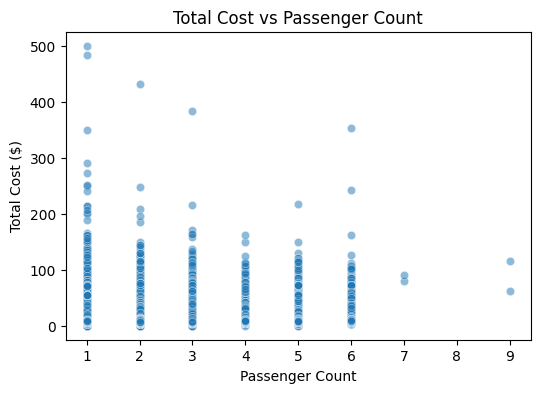

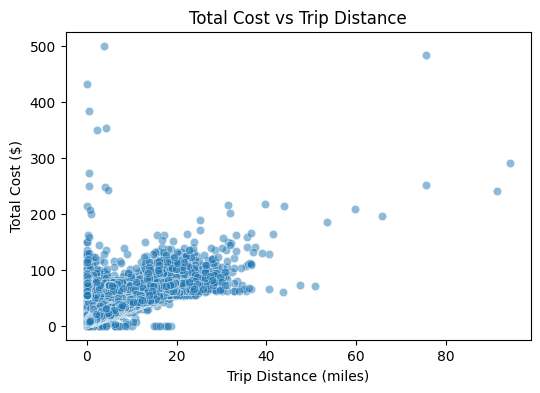

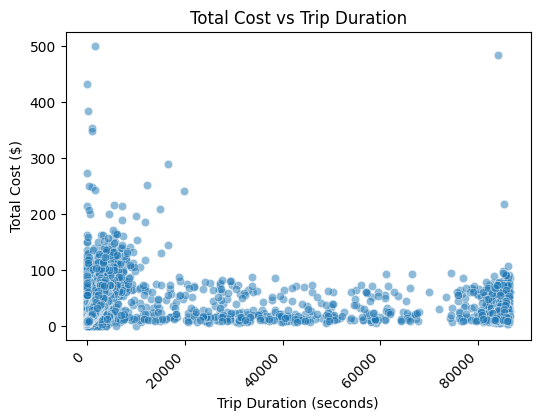

In [ ]:
# Total Cost vs Passenger Count
plt.figure(figsize=(6, 4))
sns.scatterplot(data=taxi_fare_final_df, x="passenger_count", y="total_amount", alpha=0.5)
plt.title("Total Cost vs Passenger Count")
plt.xlabel("Passenger Count")
plt.ylabel("Total Cost ($)")
plt.show()

print()

# Total Cost vs Distance
plt.figure(figsize=(6, 4))
sns.scatterplot(data=taxi_fare_final_df, x="trip_distance", y="total_amount", alpha=0.5)
plt.title("Total Cost vs Trip Distance")
plt.xlabel("Trip Distance (miles)")
plt.ylabel("Total Cost ($)")
plt.show()

print()
# Total Cost vs Trip Duration
plt.figure(figsize=(6, 4))
sns.scatterplot(data=taxi_fare_final_df, x="trip_duration", y="total_amount", alpha=0.5)
plt.title("Total Cost vs Trip Duration")
plt.xlabel("Trip Duration (seconds)")
plt.ylabel("Total Cost ($)")
plt.xticks(rotation=45, ha="right")
plt.show()

### Average Total Cost Analysis

That was a decent first attempt but as we noticed above there were outliers skewing the average trend in every relationship.  

To get more balanced insights, it will help to calculate how **Average Total Amount** varies based on different number of

*   Passengers
*   Trip Distance
*   Trip Duration

The purpose of this analysis is to identify trends and patterns that might be obscured by the presence of outliers. By grouping and averaging the data across these attributes, we aim to derive more balanced insights.

#### Average Total Cost vs Passenger Count

- **Approach**:  
   - Group the dataset by `passenger_count`.  
   - Calculate the mean `total_amount` for each group.  
   - Use a line plot to visualize the trend.  

- **Key Observations to Note**:  
   - For a typical passenger count of 1-6 passengers the average cost is pretty much the same. But after 6 passengers the cost rises dramatically. This is probably beacuse normal cars (even SUVs) can only fit 4-6 passengers max, but when there are even more passengers more heavier vans need to be used to transport.

#### Average Total Cost vs Trip Distance

- **Approach**:  
   - To create a cleaner graph, `trip_distance` is rounded to the nearest 5 miles.  
   - Group the data by the rounded distance and calculate the mean `total_amount` for each group.  
   - Use a line plot to observe trends.  

- **Key Observations to Note**:  
   - There is roughly a linear relationship between Trip Distance and Total Cost, however, there are 2 irregular patterns.
   *  Trip Distance of 50 miles has a irregular decrease in total amount.
   *  At 80 miles there is a irregular increase in total amount.
    > Note by `irregular` I mean it's outside the linear relationship.


#### Average Total Cost vs Trip Duration

- **Approach**:  
   - Convert `trip_duration` (originally in seconds) to hours for better interpretability.  
   - Round the duration to the nearest hour for a smoother trend.  
   - Group by the rounded duration and calculate the mean `total_amount`.  
   - Visualize the trend using a line plot with adjusted x-axis labels for clarity.  

- **Key Observations to Note**:  
   - The relationship is not linear, with a noticeable peak at shorter trip durations (around 2-3 hours), indicating higher costs for medium-length trips compared to longer durations.

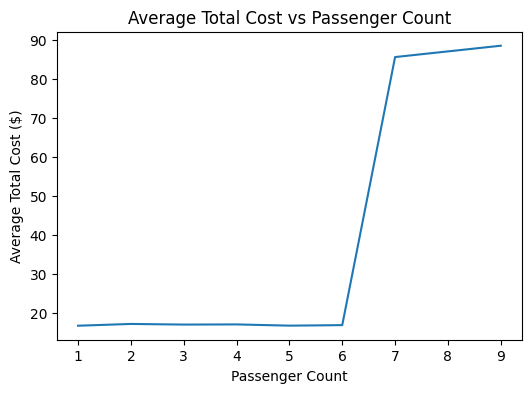

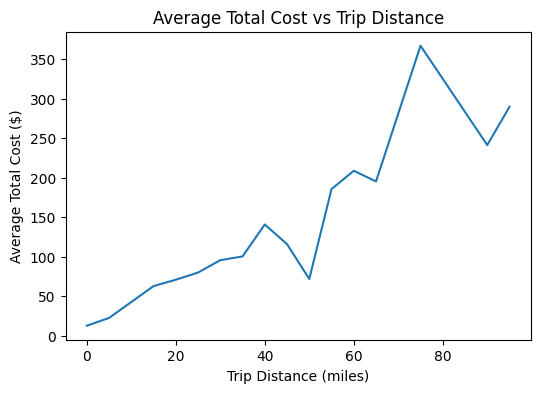

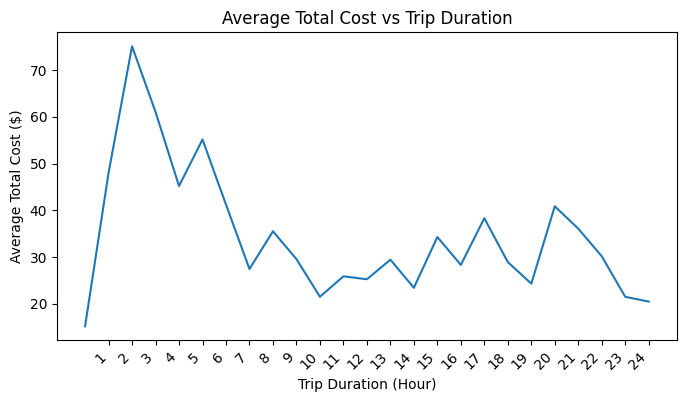

In [ ]:
# Average Total Cost vs Passenger Count
avg_cost_passenger = taxi_fare_final_df.groupby("passenger_count")["total_amount"].mean().reset_index()
plt.figure(figsize=(6, 4))
sns.lineplot(data=avg_cost_passenger, x="passenger_count", y="total_amount")
plt.title("Average Total Cost vs Passenger Count")
plt.xlabel("Passenger Count")
plt.ylabel("Average Total Cost ($)")
plt.show()

print()
# Average Total Cost vs Distance
avg_cost_distance = taxi_fare_final_df.copy()
# Round trip_distance to the nearest 5 for a cleaner graph
avg_cost_distance["trip_distance"] = avg_cost_distance["trip_distance"].apply(lambda x: 5 * round(x / 5))
avg_cost_distance = avg_cost_distance.groupby("trip_distance")["total_amount"].mean().reset_index()
plt.figure(figsize=(6, 4))
sns.lineplot(data=avg_cost_distance, x="trip_distance", y="total_amount")
plt.title("Average Total Cost vs Trip Distance")
plt.xlabel("Trip Distance (miles)")
plt.ylabel("Average Total Cost ($)")
plt.show()

print()
# Average Total Cost vs Trip Duration
avg_cost_duration = taxi_fare_final_df.copy()
# Round trip_duration to the nearest hour
avg_cost_duration["trip_duration"] = avg_cost_duration["trip_duration"].apply(lambda x: round(x / 3600))
avg_cost_duration = avg_cost_duration.groupby("trip_duration")["total_amount"].mean().reset_index()
plt.figure(figsize=(8, 4))
sns.lineplot(data=avg_cost_duration, x="trip_duration", y="total_amount")
plt.title("Average Total Cost vs Trip Duration")
plt.xlabel("Trip Duration (Hour)")
plt.ylabel("Average Total Cost ($)")
plt.xticks(ticks=list(range(1, 25)),rotation=45, ha="right")
plt.show()

### Tip Analysis
Similar to Total Cost, let's plot the following variables vs Tip to get a sense of how the data is laid out

*   Tip vs Passenger Count
*   Tip vs Trip Distance
*   Tip vs Average Speed

Finally we also draw a 3-Dimensional graph to see how Tip vs Trip Distance vs Passenger Count are related



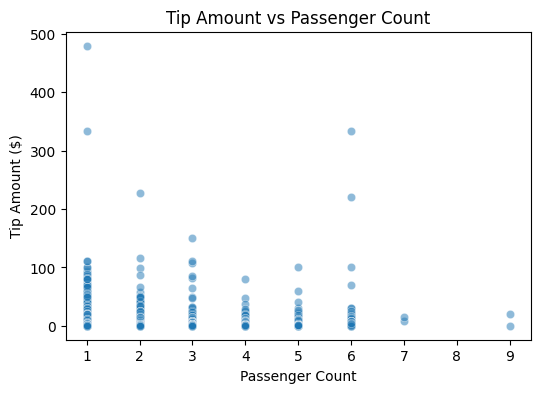

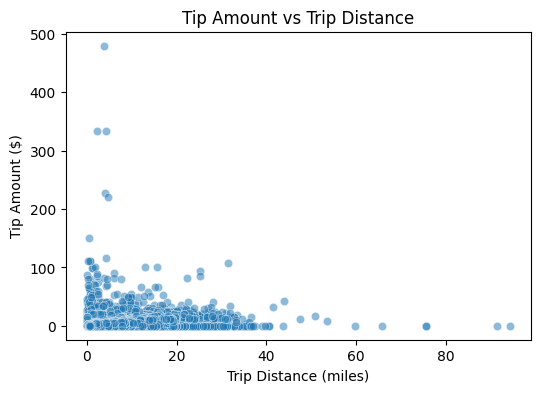

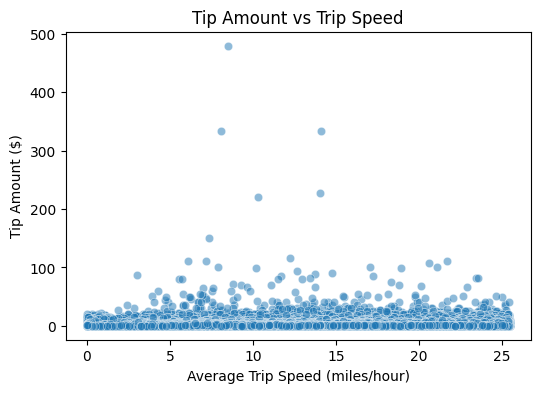

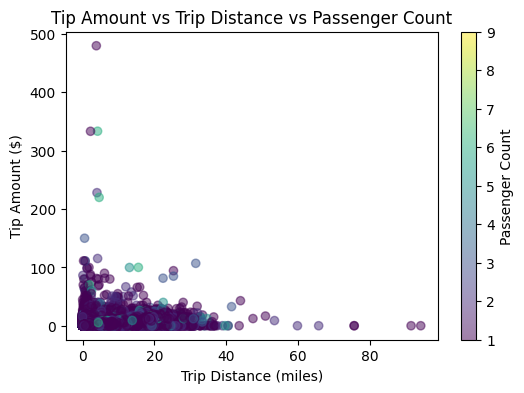

In [ ]:
# Tip vs Passenger Count
plt.figure(figsize=(6, 4))
sns.scatterplot(data=taxi_fare_final_df, x="passenger_count", y="tip_amount", alpha=0.5)
plt.title("Tip Amount vs Passenger Count")
plt.xlabel("Passenger Count")
plt.ylabel("Tip Amount ($)")
plt.show()

print()

# Tip vs Distance
plt.figure(figsize=(6, 4))
sns.scatterplot(data=taxi_fare_final_df, x="trip_distance", y="tip_amount", alpha=0.5)
plt.title("Tip Amount vs Trip Distance")
plt.xlabel("Trip Distance (miles)")
plt.ylabel("Tip Amount ($)")
plt.show()

print()

# Tip vs Trip Speed
plt.figure(figsize=(6, 4))
sns.scatterplot(data=taxi_fare_final_df, x="average_speed", y="tip_amount", alpha=0.5)
plt.title("Tip Amount vs Trip Speed")
plt.xlabel("Average Trip Speed (miles/hour)")
plt.ylabel("Tip Amount ($)")
plt.show()

print()

# Tip Amount vs Passenger Count vs Trip Distance
plt.figure(figsize=(6, 4))
plt.scatter(taxi_fare_final_df["trip_distance"], taxi_fare_final_df["tip_amount"], c=taxi_fare_final_df["passenger_count"], cmap="viridis", alpha=0.5)
cbar = plt.colorbar()
cbar.set_label("Passenger Count")
plt.title("Tip Amount vs Trip Distance vs Passenger Count")
plt.xlabel("Trip Distance (miles)")
plt.ylabel("Tip Amount ($)")
plt.show()

### Average Tip Analysis

Now we will identify trends and patterns in tipping behavior, which might be influenced by factors such as group size, trip length, and speed. By grouping and averaging the data across these attributes, we aim to balanced meaningful insights that can be generalized for the average.

#### Average Tip Amount vs Passenger Count

- **Approach**:  
   - Group the dataset by `passenger_count`.  
   - Calculate the mean `tip_amount` for each group.  
   - Use a line plot to visualize.

- **Key Observations to Note**:  
   - Similar to Average Total Amount of the trip, Average tip is also roughly the same for passenger count of 1 to 6 but for passenger count of 7 and above there is a sharp increase in tip amount.
   - 7 Passengers particularly showed highest average tipping.

#### Average Tip Amount vs Trip Distance

- **Approach**:  
   - To create a cleaner graph, `trip_distance` is rounded to the nearest 5 miles.  
   - Group the data by the rounded distance and calculate the mean `tip_amount` for each group.  
   - Use a line plot to visualize.

- **Key Observations to Note**:  
   - Tips increase steadily with trip distance up to approximately 45 miles, after which there is a sharp decline.
   - Trips longer than 60 miles result in negligible or no tips.

#### Average Tip Amount vs Trip Speed

- **Approach**:  
   - Round `average_speed` (in miles per hour) to the nearest integer for a smoother trend.  
   - Group the data by the rounded speed and calculate the mean `tip_amount` for each group.  
   - Use a line plot to visualize the trend.  

- **Key Observations to Note**:  
   - Tips generally increase with average speed, suggesting that faster trips may correlate with higher passenger satisfaction and generosity.
   - There is an initial irregular drop at roughly 3 miles per hour, after which the trend becomes more stable.

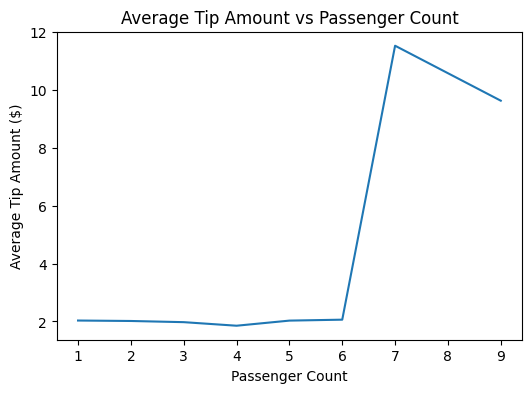

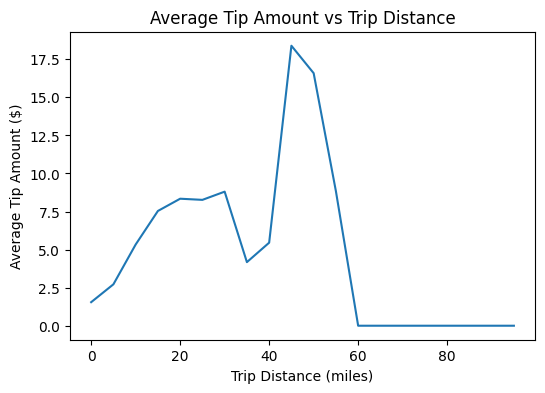

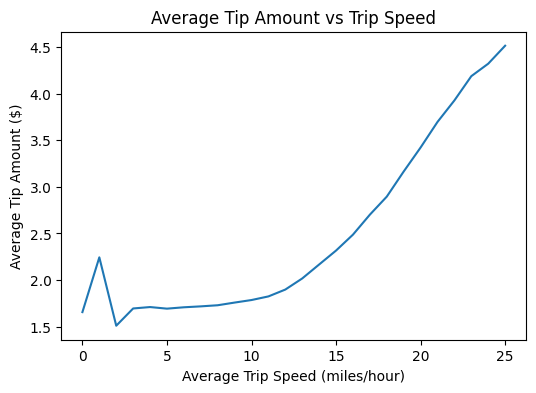

In [ ]:
# Average Tip vs Passenger Count
avg_tip_passenger = taxi_fare_final_df.groupby("passenger_count")["tip_amount"].mean().reset_index()
plt.figure(figsize=(6, 4))
sns.lineplot(data=avg_tip_passenger, x="passenger_count", y="tip_amount")
plt.title("Average Tip Amount vs Passenger Count")
plt.xlabel("Passenger Count")
plt.ylabel("Average Tip Amount ($)")
plt.show()

print()

# Average Tip vs Distance
avg_tip_distance = taxi_fare_final_df.copy()
# Round trip_distance to the nearest 5 for a cleaner graph
avg_tip_distance["trip_distance"] = avg_tip_distance["trip_distance"].apply(lambda x: 5 * round(x / 5))
avg_tip_distance = avg_tip_distance.groupby("trip_distance")["tip_amount"].mean().reset_index()
plt.figure(figsize=(6, 4))
sns.lineplot(data=avg_tip_distance, x="trip_distance", y="tip_amount")
plt.title("Average Tip Amount vs Trip Distance")
plt.xlabel("Trip Distance (miles)")
plt.ylabel("Average Tip Amount ($)")
plt.show()

print()

# Average Tip vs Trip Speed
avg_tip_speed = taxi_fare_final_df.copy()
# Round average_speed to the nearest mile for a cleaner graph
avg_tip_speed["average_speed"] = avg_tip_speed["average_speed"].apply(lambda x: round(x))
avg_tip_speed = avg_tip_speed.groupby("average_speed")["tip_amount"].mean().reset_index()
plt.figure(figsize=(6, 4))
sns.lineplot(data=avg_tip_speed, x="average_speed", y="tip_amount")
plt.title("Average Tip Amount vs Trip Speed")
plt.xlabel("Average Trip Speed (miles/hour)")
plt.ylabel("Average Tip Amount ($)")
plt.show()

### Trip cost per Borough's Pick Up and Drop Off Location

The purpose of this analysis is to highlight geographic cost pattern. We aim to sunderstand how the average total cost of taxi rides varies based on the pick-up and drop-off boroughs in NYC. This helps identify areas with higher fares, such as Newark (EWR) and Staten Island, which may be influenced by factors like airport surcharges or longer travel distances. We also learn surprisingly that Manhattan has low total cost because which we stipulate is because of short trips.

#### Procedure:
1. **Pick-Up Borough Analysis**:  
   - The data is grouped by `pick_up_borough` to calculate the average `total_amount` for each borough.
   - A bar plot is used to visualize.

2. **Drop-Off Borough Analysis**:  
   - Similarly, the data is grouped by `drop_off_borough` to calculate the average `total_amount` for each borough.
   - Bar plot for visualization.


#### **Key Observations: Pick-Up Borough**
1. Newark (EWR) has the highest average total cost, significantly outpacing all other boroughs.
2. Manhattan has the lowest average total cost, likely reflecting shorter trip distances within the borough because otherwise Manhattan is expensive.


#### **Key Observations: Drop-Off Borough**
1. Similar to pick-up boroughs, Newark (EWR) shows the highest average total cost for drop-offs, reinforcing the influence of airport-related trips.  
2. Staten Island and Queens also exhibit higher average costs compared to other boroughs, possibly reflecting longer average trip distances.

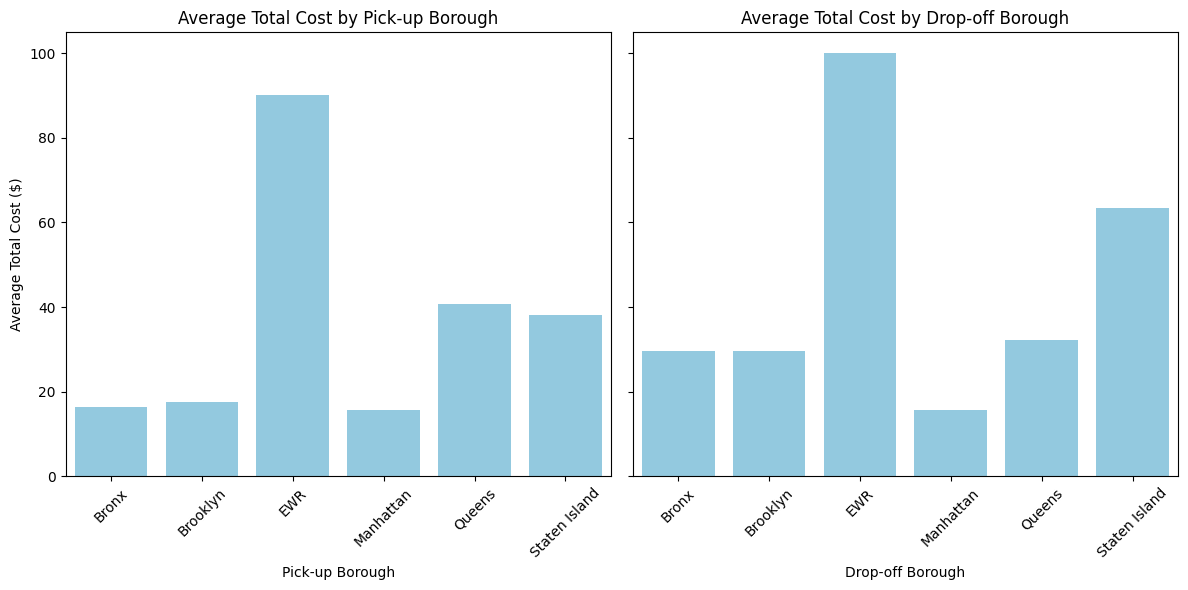

In [ ]:
# Group data by pick-up borough and calculate the average total amount
pickup_borough_fare = taxi_fare_final_df.groupby("pick_up_borough")["total_amount"].mean().reset_index()

# Group data by drop-off borough and calculate the average total amount
dropoff_borough_fare = taxi_fare_final_df.groupby("drop_off_borough")["total_amount"].mean().reset_index()

# Create subplots to show the two graphs side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Plot for pick-up borough
sns.barplot(ax=axes[0], data=pickup_borough_fare, x="pick_up_borough", y="total_amount", color="skyblue")
axes[0].set_title("Average Total Cost by Pick-up Borough")
axes[0].set_xlabel("Pick-up Borough")
axes[0].set_ylabel("Average Total Cost ($)")
axes[0].tick_params(axis='x', rotation=45)

# Plot for drop-off borough
sns.barplot(ax=axes[1], data=dropoff_borough_fare, x="drop_off_borough", y="total_amount", color="skyblue")
axes[1].set_title("Average Total Cost by Drop-off Borough")
axes[1].set_xlabel("Drop-off Borough")
axes[1].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()


### Average Tip for Rides in Each Borough's Pick Up and Drop Off

The purpose of this analysis is to highlight geographic tip pattern. We aim to sunderstand how the average tip of taxi rides varies based on the pick-up and drop-off boroughs in NYC.

#### Procedure:
1. **Pick-Up Borough Analysis**:  
   - The data is grouped by `pick_up_borough` to calculate the average `tip_amount` for each borough.
   - A bar plot is used to visualize.

2. **Drop-Off Borough Analysis**:  
   - Similarly, the data is grouped by `drop_off_borough` to calculate the average `tip_amount` for each borough.
   - Bar plot for visualization.


#### **Key Observations: Pick-Up Borough**
1. Newark (EWR) has the highest average tip, significantly outpacing all other boroughs.


#### **Key Observations: Drop-Off Borough**
1. Similar to pick-up boroughs, Newark (EWR) shows the highest average tip for drop-offs, reinforcing the influence of airport-related trips.

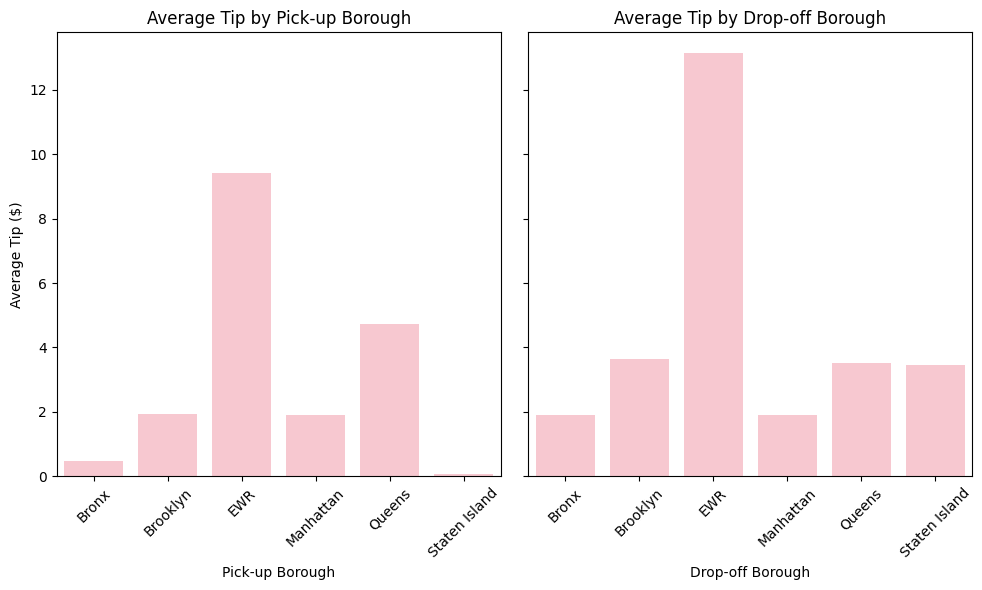

In [ ]:
# Group data by pick-up borough and calculate the average tip amount
pickup_borough_tip = taxi_fare_final_df.groupby("pick_up_borough")["tip_amount"].mean().reset_index()

# Group data by drop-off borough and calculate the average tip amount
dropoff_borough_tip = taxi_fare_final_df.groupby("drop_off_borough")["tip_amount"].mean().reset_index()

# Create subplots to show the two graphs side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 6), sharey=True)

# Plot for pick-up borough with pink bars
sns.barplot(ax=axes[0], data=pickup_borough_tip, x="pick_up_borough", y="tip_amount", color="pink")
axes[0].set_title("Average Tip by Pick-up Borough")
axes[0].set_xlabel("Pick-up Borough")
axes[0].set_ylabel("Average Tip ($)")
axes[0].tick_params(axis='x', rotation=45)

# Plot for drop-off borough
sns.barplot(ax=axes[1], data=dropoff_borough_tip, x="drop_off_borough", y="tip_amount", color="pink")
axes[1].set_title("Average Tip by Drop-off Borough")
axes[1].set_xlabel("Drop-off Borough")
axes[1].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()


### The Busiest Time of Day

#### Purpose:
Here we will determine the distribution of taxi rides across different times of the day in order to identify peak activity periods during the day.

#### Procedure:
1. The data is grouped by `PU_time_of_day` (pickup time of day), and the total number of rides (`ride_count`) is calculated for each time period.  
2. Time periods are ordered categorically.
3. A line plot is used to display the number of rides for each time of day.

#### **Key Observations**
1. **Afternoon** is the busiest time for rides, followed by **Morning** and **Night**.
2. **Noon** and **Midnight** show the lowest activity, indicating off-peak hours for taxi demand.  

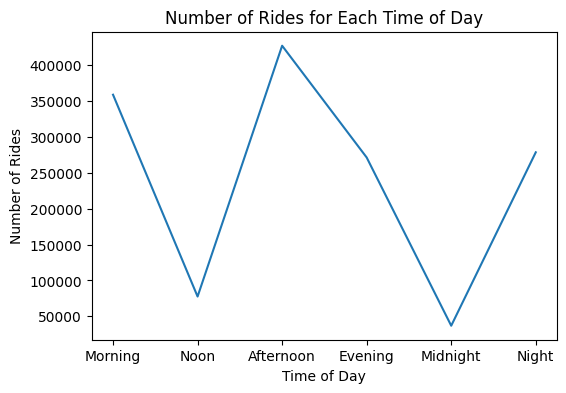

In [ ]:
# Group data by day and time of day, and calculate the average number of rides
rides_per_time_of_day = taxi_fare_final_df.groupby(["PU_time_of_day"])["VendorID"].count().reset_index()
rides_per_time_of_day = rides_per_time_of_day.rename(columns={"VendorID": "ride_count"})

# Convert 'PU_time_of_day' to categorical with desired order
categories = ["Morning", "Noon", "Afternoon", "Evening", "Midnight", "Night"]
rides_per_time_of_day["PU_time_of_day"] = pd.Categorical(rides_per_time_of_day["PU_time_of_day"], categories=categories, ordered=True)

# Create a line plot showing average number of rides for each time of day for each day
plt.figure(figsize=(6, 4))
sns.lineplot(data=rides_per_time_of_day, x="PU_time_of_day", y="ride_count")
plt.title("Number of Rides for Each Time of Day")
plt.xlabel("Time of Day")
plt.ylabel("Number of Rides")
plt.show()

### Average Total Cost vs Time of Day

#### Purpose:
Lets explore how **Average Total Cost** of rides varies across different times of the day. We saw that number of rides very alot based on the time of the day, but does that affect Average cost too?

#### Procedure:
- The data is grouped by `PU_time_of_day` (pickup time of day), and the average `total_amount` is calculated for each time period.  
- A bar plot is then used to visualize.

#### **Key Observations**
1. The average cost remains relatively consistent across the other time periods, with no sharp declines or increases outside the afternoon peak.  
2. **Afternoon** has a slightly higher average total cost, likely due to higher demand during this period.

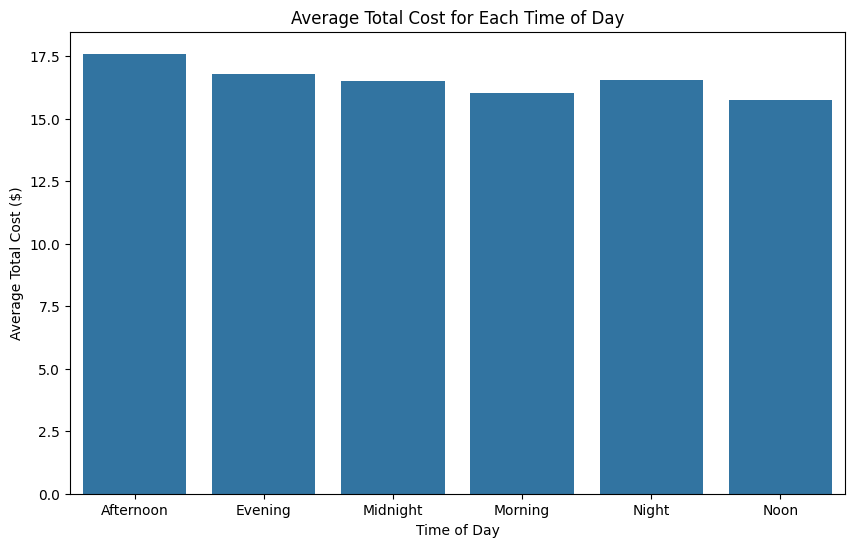

In [ ]:
# Group data by time of day and calculate the average total cost
average_cost_by_time_of_day = taxi_fare_final_df.groupby("PU_time_of_day")["total_amount"].mean().reset_index()

# Create a bar plot showing average total cost for each time of day
plt.figure(figsize=(10, 6))
sns.barplot(data=average_cost_by_time_of_day, x="PU_time_of_day", y="total_amount")
plt.title("Average Total Cost for Each Time of Day")
plt.xlabel("Time of Day")
plt.ylabel("Average Total Cost ($)")
plt.show()

## Which month was the fastest?

Earlier in pre-processing we saw that average speed varies per month. Lets confirm this with our own dataset. Which month saw the highest average speed?

**Check how many trips belong to each month**

First we need to check how many months are represented in our dataset.

**Observation:** We can observe that not all months are represented in our dataset but we still can get a sense of speeds across these months.


In [ ]:
# get only the months from the date time
months_df = pd.DataFrame(taxi_fare_final_df["pick_up_datetime"].dt.month_name())
months_df.columns = ["month"]
months_df.groupby("month").count()

""
month
April
February
January
July
March
May


In [ ]:
# First calculate the average speed for each month and store that in dataframe.
average_speed_df = pd.DataFrame(taxi_fare_final_df.groupby(taxi_fare_final_df["pick_up_datetime"].dt.month_name())["average_speed"].mean())
average_speed_df.columns = ["average_speed"]

# Define custom month order to order the months
month_order = ['January', 'February', 'March', 'April', 'May', 'July']

# Reorder the rows of the DataFrame based on custom month order
average_speed_df = average_speed_df.reindex(month_order)

display(average_speed_df)



,average_speed
pick_up_datetime,
January,10.784332
February,12.483364
March,3.234629
April,4.181818
May,6.753737
July,7.678991


**Observations:**


*   February is slightly faster than January.
*   There is a sudden drop in speed from February to March. But between March and July the average speed grows linearly per month.



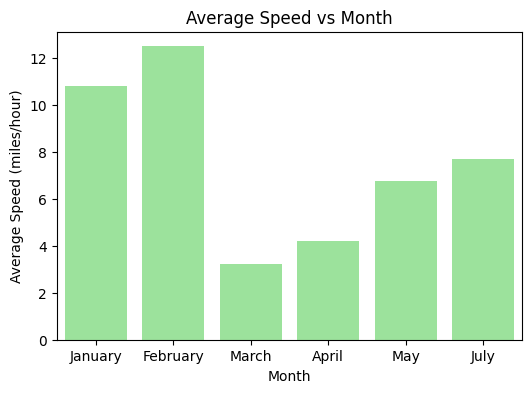

In [ ]:
# Draw using sns
plt.figure(figsize=(6, 4))
sns.barplot(data=average_speed_df, x=average_speed_df.index, y="average_speed", color="lightgreen")
plt.title("Average Speed vs Month")
plt.xlabel("Month")
plt.ylabel("Average Speed (miles/hour)")
plt.show()

## Correlation Matrix
Correlation between passenger count, trip distance, fare amount, extra charges, mta tax, tip amount, tolls amount, improvement surcharge, total amount, and congestion surcharge

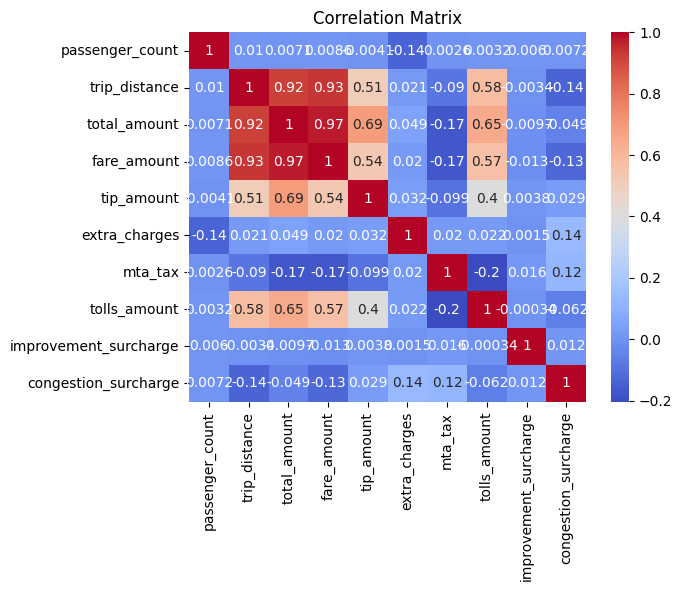

In [ ]:
corr_matrix = taxi_fare_final_df[["passenger_count", "trip_distance", "total_amount", "fare_amount", "tip_amount", "extra_charges", "mta_tax", "tolls_amount", "improvement_surcharge", "congestion_surcharge"]].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

# **Model Implementation**

Our focus will be to **predict** `total_amount` which is the total cost of a trip.

**Features:**

We will drop boroughs and zones, encode other non-numerical features with numbers such as time of day and DateTime. As we saw earlier in EDA, most of our variables are uncorrelated and there is only moderate positive pairwise correlation between `trip_distance`, `fare_amount` and `tolls_amount`.

**Game Plan:**

After pre-processing we will use an unregularized Linear Regression with hyperparameter tuning as our baseline. We then conduct L1 and L2 regularized linear regressions each with hyperparameter tuning and compare it with baseline. Our final model will be an XGBoost Model which we tune using RandomSearchCV.

In [ ]:
trip_model_df = taxi_fare_final_df.copy()
trip_model_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449542 entries, 0 to 1449541
Data columns (total 27 columns):
 #   Column                        Non-Null Count    Dtype         
---  ------                        --------------    -----         
 0   VendorID                      1449542 non-null  float64       
 1   pick_up_datetime              1449542 non-null  datetime64[ns]
 2   drop_off_datetime             1449542 non-null  datetime64[ns]
 3   passenger_count               1449542 non-null  float64       
 4   trip_distance                 1449542 non-null  float64       
 5   PULocationID                  1449542 non-null  int64         
 6   DOLocationID                  1449542 non-null  int64         
 7   payment_type                  1449542 non-null  float64       
 8   fare_amount                   1449542 non-null  float64       
 9   extra_charges                 1449542 non-null  float64       
 10  mta_tax                       1449542 non-null  float64       
 11

## Preprocessing

### Convert DateTime into Numerical Format
We do this by extracting the year, month, and day for each datetime

We don't need to extract the time because we already have the time_of_day, which we will convert later

In [ ]:
# Extract the Year, Month, Day, and time from pick_up_datetime
trip_model_df["pick_up_year"] = trip_model_df["pick_up_datetime"].dt.year
trip_model_df["pick_up_month"] = trip_model_df["pick_up_datetime"].dt.month
trip_model_df["pick_up_day"] = trip_model_df["pick_up_datetime"].dt.day

# Extract the Year, Month, Day, and time from drop_off_datetime
trip_model_df["drop_off_year"] = trip_model_df["drop_off_datetime"].dt.year
trip_model_df["drop_off_month"] = trip_model_df["drop_off_datetime"].dt.month
trip_model_df["drop_off_day"] = trip_model_df["drop_off_datetime"].dt.day

trip_model_df = trip_model_df.drop(columns=["pick_up_datetime", "drop_off_datetime"])

trip_model_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449542 entries, 0 to 1449541
Data columns (total 31 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   VendorID                      1449542 non-null  float64
 1   passenger_count               1449542 non-null  float64
 2   trip_distance                 1449542 non-null  float64
 3   PULocationID                  1449542 non-null  int64  
 4   DOLocationID                  1449542 non-null  int64  
 5   payment_type                  1449542 non-null  float64
 6   fare_amount                   1449542 non-null  float64
 7   extra_charges                 1449542 non-null  float64
 8   mta_tax                       1449542 non-null  float64
 9   tip_amount                    1449542 non-null  float64
 10  tolls_amount                  1449542 non-null  float64
 11  improvement_surcharge         1449542 non-null  float64
 12  total_amount                

### Convert Time of Day to Numerical Format

In [ ]:
time_of_day_mapping = {
    "Midnight": 0,
    "Morning": 1,
    "Noon": 2,
    "Afternoon": 3,
    "Evening": 4,
    "Night": 5
}

trip_model_df["PU_time_of_day"] = trip_model_df["PU_time_of_day"].apply(lambda x: time_of_day_mapping.get(x, x))
trip_model_df["DO_time_of_day"] = trip_model_df["DO_time_of_day"].apply(lambda x: time_of_day_mapping.get(x, x))
trip_model_df[["PU_time_of_day", "DO_time_of_day"]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449542 entries, 0 to 1449541
Data columns (total 2 columns):
 #   Column          Non-Null Count    Dtype
---  ------          --------------    -----
 0   PU_time_of_day  1449542 non-null  int64
 1   DO_time_of_day  1449542 non-null  int64
dtypes: int64(2)
memory usage: 22.1 MB


### Drop the Borough and Zone columns
We do this because we already have LocationIDs that uniquely identifies them

In [ ]:
trip_model_df = trip_model_df.drop(columns=["pick_up_borough", "pick_up_zone", "drop_off_borough", "drop_off_zone"])
trip_model_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449542 entries, 0 to 1449541
Data columns (total 27 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   VendorID                      1449542 non-null  float64
 1   passenger_count               1449542 non-null  float64
 2   trip_distance                 1449542 non-null  float64
 3   PULocationID                  1449542 non-null  int64  
 4   DOLocationID                  1449542 non-null  int64  
 5   payment_type                  1449542 non-null  float64
 6   fare_amount                   1449542 non-null  float64
 7   extra_charges                 1449542 non-null  float64
 8   mta_tax                       1449542 non-null  float64
 9   tip_amount                    1449542 non-null  float64
 10  tolls_amount                  1449542 non-null  float64
 11  improvement_surcharge         1449542 non-null  float64
 12  total_amount                

## Split into Train and Test

Our goal is to predict the total cost of a NYC taxi ride

In [ ]:
features = trip_model_df.drop(columns=["total_amount"])
target = trip_model_df["total_amount"]

X_train, X_test, y_train, y_test = train_test_split(features, target, train_size=0.8, test_size=0.2, random_state=42)

## Baseline: Unregularized Linear Regression

Using an unregularized linear regression model to predict the total amount in our taxi fare dataset is a reasonable initial approach for several reasons.


1.   Linear regression is a simple and interpretable model, making it easy to understand the relationships between the predictor variables (like trip distance, time of day, etc.) and the target variable (total amount).
2.   Our dataset has many linear relationships between some features such as trip distance and fare and `total_amount`.
3. unregularized linear regression provides a baseline performance which will allow us to see the benefits of more complex techniques and regularizations.

In [ ]:
from sklearn.linear_model import LinearRegression

# Initialize model with default parameters and fit it on the training set
reg = LinearRegression()
reg.fit(X_train, y_train)

# predict
y_pred = reg.predict(X_test)

# get the score
lin_reg_score = round(reg.score(X_test, y_test), 4)

# get the mse
lin_reg_mse = round(mean_squared_error(y_test, y_pred), 4)

# Take the square root of the mse to find the rmse
lin_reg_rmse = round(np.sqrt(lin_reg_mse), 4)

print("Score:", lin_reg_score, "MSE:", lin_reg_mse, "RMSE:", lin_reg_rmse)

Score: 0.9995 MSE: 0.0534 RMSE: 0.2311


### Hypertuning Parameters with GridSearchCV

We used grid search to hypertune the unregularized linear model because it systematically explores a predefined set of hyperparameter values and speed wasn't a concern here.

Grid search exhaustively evaluates all possible combinations within the specified grid of parameters that we defined, guaranteeing that we identify the optimal settings for our model.

>Takes CPU ~3m 50s to run

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid to search
param_grid = {
    'fit_intercept': [True, False],
    'copy_X': [True, False],
    'positive': [True, False],
    'n_jobs': [1,5,10,15,None]
}

# Create GridSearchCV and fit on the training set
grid_search = GridSearchCV(estimator=reg, param_grid=param_grid)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

# Get the best model
best_reg_model = grid_search.best_estimator_

# Predict
y_pred = best_reg_model.predict(X_test)

# Evaluate the best model
best_reg_score = round(best_reg_model.score(X_test, y_test), 4)
best_reg_mse = round(mean_squared_error(y_test, y_pred), 4)
best_reg_rmse = round(np.sqrt(best_reg_mse), 4)

print("Score:", best_reg_score, "MSE:", best_reg_mse, "RMSE:", best_reg_rmse)

Best Hyperparameters: {'copy_X': True, 'fit_intercept': True, 'n_jobs': 1, 'positive': False}
Score: 0.9995 MSE: 0.0534 RMSE: 0.2311


We can see that Unregularized Linear Regression performed fairly well before and after hypertuning its parameters. \\
We hypothesize the reasons as below: \\

1. **Low Noise**: The low MSE and RMSE values indicate that our data have relatively low noise or random error. This is due to our extensive efforts to remove outliers based on many factors earlier in pre-processing.

1. **Linear Relationship**: The high R-squared score shows a strong linear relationship between our predictor variables and the target variable, `total_amount`.

2. **Relevant Features**: The features we extracted like trip duration, average trip speed are highly relevant in determining the total cost of taxi fares and are linearly related. The inclusion of these features in the model helps explain a large portion of the variance in fares (thus high R-squared value)

In [ ]:
# Get the feature names from the training set
feature_names = X_train.columns

# Create a DataFrame to store feature names and their coefficients
coefficients = pd.DataFrame({
    "Feature": feature_names,  # Use the feature names from the training data
    "Coefficient": best_reg_model.coef_   # Coefficients from the Lasso model
})

# Sort the DataFrame by the absolute value of the coefficients in descending order
coefficients = coefficients.sort_values(by="Coefficient", key=np.abs, ascending=False)

In [ ]:
print(coefficients)

                         Feature   Coefficient
24                drop_off_month  3.396745e+00
21                 pick_up_month -3.373864e+00
0                       VendorID  1.737661e+00
9                     tip_amount  1.004221e+00
10                  tolls_amount  1.002493e+00
6                    fare_amount  9.985230e-01
12          congestion_surcharge  7.796029e-01
7                  extra_charges  7.269612e-01
8                        mta_tax  6.763388e-01
11         improvement_surcharge  6.761886e-01
25                  drop_off_day  1.095599e-01
22                   pick_up_day -1.092734e-01
14                DO_time_of_day  2.869984e-02
2                  trip_distance  1.045322e-02
13                PU_time_of_day  9.167432e-03
19                 average_speed -2.087794e-03
17         tip_per_unit_distance -1.650910e-03
15   base_fare_per_unit_distance -1.454380e-03
16  total_cost_per_unit_distance  1.365007e-03
5                   payment_type  7.032817e-04
1            

### PCA on Linear Regression Model

> We want to test if our model is overfitting thus we try PCA.


> Another reason is that we have many features which is a good case for PCA.

> Even though our EDA showcased little multi-collinearity among the features but there was some moderate correlation which we try to remove by reducing the dimensionality of our model. Better safe than sorry.



In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit PCA to retain 95% variance
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

plot the explained variance

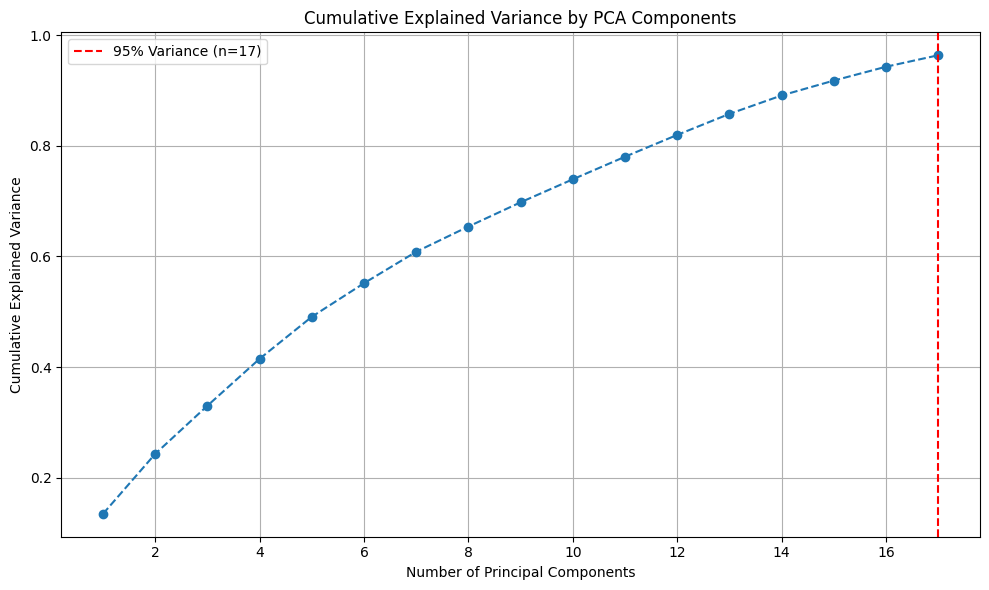

In [ ]:
# Get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plot the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')

# Highlight the 95% variance point
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
plt.axvline(x=n_components_95, color='r', linestyle='--', label=f'95% Variance (n={n_components_95})')

# Add labels and title
plt.title("Cumulative Explained Variance by PCA Components")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid()
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

This way we reduce our dimensionality by choosing 17 prinicpal components instead of 24 original features. Now lets see how our model performs

Model Retraining and Evaluation

In [ ]:
# Fit PCA with 17 components
pca = PCA(n_components=17, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Train Linear Regression Model on PCA-reduced data
lr_pca = LinearRegression()
lr_pca.fit(X_train_pca, y_train)

# Evaluate the model on PCA-reduced data
y_pred_lr_pca = lr_pca.predict(X_test_pca)

# Calculate metrics
lr_pca_r2 = round(lr_pca.score(X_test_pca, y_test), 4)
lr_pca_mse = round(mean_squared_error(y_test, y_pred_lr_pca), 4)
lr_pca_rmse = round(np.sqrt(lr_pca_mse), 4)

# Print results
print("R2 Score:", lr_pca_r2, "MSE:", lr_pca_mse, "RMSE:", lr_pca_rmse)

R2 Score: 0.9869 MSE: 1.3886 RMSE: 1.1784


We can see that after using PCA on the Unregularized Linear Regression Model, the model performed worse. \\
The reasons we hypothesize are: \\
1. **Information Loss**: PCA reduced dimensionality from 24 features to 17 uncorrelated principal components. While this can be beneficial for certain models in our case it ended up removing features that covered that missing bit of variance in our model.
2. **No significant Multicollinearity**: Our features dont showcase significant multi-collinearity and thus removing PCA doesn't help the model.
3. **Model not overfitting**: Lower PCA's score shows that our original model wasn't overfitting.

## Model 2: Regularized Linear Regression

### Lasso Regression ($L_1$)

Since PCA didn't do a great job at dimension reduction we try Lasso L1 regularization as our next step.

Lasso makes features go to zero and redistributes the weight to more important features. This effectively reduces the dimensionality and increase the simplicity of our model. So let's try

In [ ]:
from sklearn.linear_model import Lasso

# Initialize model and fit it on the training set
lasso = Lasso()
lasso.fit(X_train, y_train)

# Predict on the test set
y_pred = lasso.predict(X_test)

# Evaluate the model
lasso_score = round(lasso.score(X_test, y_test), 4)
lasso_mse = round(mean_squared_error(y_test, y_pred), 4)
lasso_rmse = round(np.sqrt(lasso_mse), 4)

print("R2 Score:", lasso_score, "MSE:", lasso_mse, "RMSE:", lasso_rmse)

R2 Score: 0.9854 MSE: 1.549 RMSE: 1.2446


**Print the coefficients**

Lets visualize what features were used primarily for predicting our `total_amount` and which variables did Lasso set to zero. in short, which features were deemed most important by Lasso.

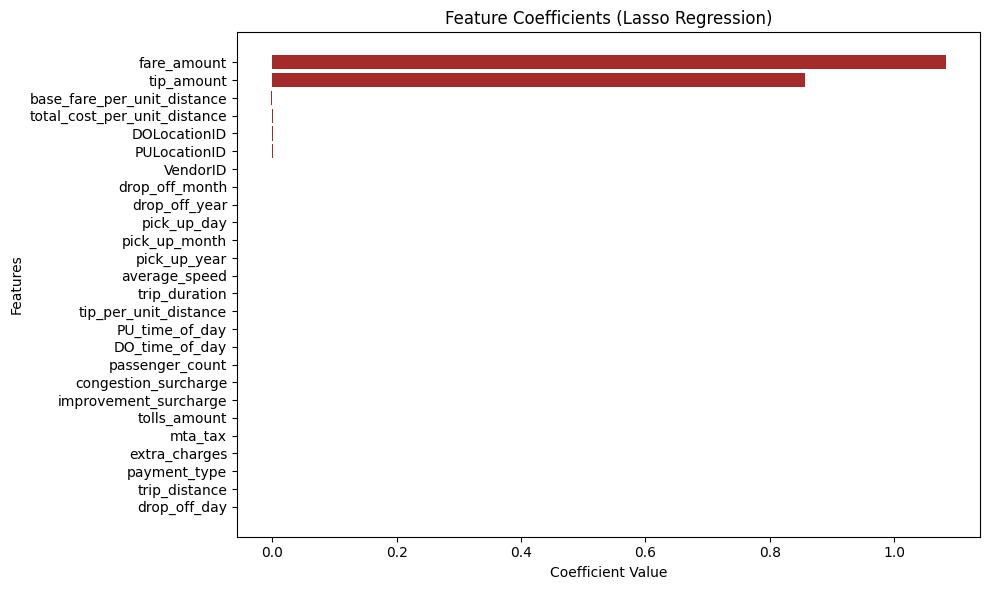

In [ ]:
# Get the feature names from the training set
feature_names = X_train.columns

# Create a DataFrame to store feature names and their coefficients
coefficients = pd.DataFrame({
    "Feature": feature_names,  # Use the feature names from the training data
    "Coefficient": lasso.coef_   # Coefficients from the Lasso model
})

# Sort the DataFrame by the absolute value of the coefficients in descending order
coefficients = coefficients.sort_values(by="Coefficient", key=np.abs, ascending=False)

# Plot the coefficients
plt.figure(figsize=(10, 6))
plt.barh(coefficients["Feature"], coefficients["Coefficient"], color='brown')
plt.xlabel("Coefficient Value")
plt.ylabel("Features")
plt.title("Feature Coefficients (Lasso Regression)")
plt.gca().invert_yaxis()  # Invert y-axis to have the highest coefficient at the top
plt.tight_layout()
plt.show()

**Interpretation**

The main takeaway of Lasso is
*   Lasso focused primarily on two features which were `fare_amount` and `tip_amount` causing **Underfitting** for the model thus lower R-squared

Our baseline unregularized linear regression significantly outperforms Lasso in terms of R² (0.9995 vs. 0.9854), MSE (0.0534 vs. 1.549), and RMSE (0.2311 vs. 1.2446). This suggests Lasso's feature selection and regularization are overly aggressive for this dataset, underfitting the model.

>



#### Hypertuning Parameters with RandomizedSearchCV
Grid search can become computationally expensive, especially with a wide range of values for alpha, while randomized search samples a fixed number of random combinations.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

# Define the hyperparameter distribution to search
param_dist = {
    "alpha": uniform(loc=0.001, scale=10),  # Uniform distribution between 0.001 and 10
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=lasso, param_distributions=param_dist, n_iter=10, random_state=42)

# Fit on training set
random_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = random_search.best_params_
print(f"Best Hyperparameters: {best_params}")

# Get the best model
best_lasso_model = random_search.best_estimator_

# Predict
y_pred = best_lasso_model.predict(X_test)

# Evaluate the best model
best_lasso_score = round(best_lasso_model.score(X_test, y_test), 4)
best_lasso_mse = round(mean_squared_error(y_test, y_pred), 4)
best_lasso_rmse = round(np.sqrt(best_lasso_mse), 4)

print("Score:", best_lasso_score, "MSE:", best_lasso_mse, "RMSE:", best_lasso_rmse)

Best Hyperparameters: {'alpha': 0.5818361216819946}
Score: 0.9919 MSE: 0.8643 RMSE: 0.9297


We can see that without hypertuning, Lasso Regression performed worse than Unregularized Linear Regression, but after hypertuning, Lasso Regression performed much better but is still worse than Unregularized Linear Regression. \\

Key Takeaway:

**Penalty Strength**: The default penalty strength (alpha) in Lasso Regression might have been too high for your data. A strong penalty could excessively shrink the coefficients of important features, hindering the model's ability to capture the true relationships in the data.

> However, why did Unregularized Linear Model still perform sligtly better?

We hypothesize the reason is

**Bias-Variance Tradeoff**: Lasso introduces bias to the model in exchange for reduced variance. In our case, due to sufficient pre-processing and outlier removal, unregularized linear regression already has low variance. Therefore, the added bias from Lasso outweighs the reduction in variance, leading to a slightly worse performance.


### Ridge Regression ($L_2$)

Since Lasso regression didn't work, we aim to use Ridge as our next intuitive choice for regularization. We noticed that Lasso setting coefficients to zero decreased performance therefore we used Ridge as an alternative since Ridge regression doesn't set features to zero but decreases their effect which maybe suitable for our usecase.



In [ ]:
from sklearn.linear_model import Ridge

# Initialize model and fit it on the training set
ridge = Ridge()
ridge.fit(X_train, y_train)

# Predict on the test set
y_pred = ridge.predict(X_test)

# Evaluate the model
ridge_score = round(ridge.score(X_test, y_test), 4)
ridge_mse = round(mean_squared_error(y_test, y_pred), 4)
ridge_rmse = round(np.sqrt(ridge_mse), 4)

print("R2 Score:", ridge_score, "MSE:", ridge_mse, "RMSE:", ridge_rmse)

R2 Score: 0.9995 MSE: 0.0534 RMSE: 0.2311


#### Hypertuning Parameters with RandomizedSearchCV

Here we use `X_train_scaled` and `X_test_scaled` to improve the numerical stability of the regression calculation. That is because `X_train` causes `LinAlgWarning: Ill-conditioned matrix` warnings, which indicates potential issues with the stability and accuracy of the solution.

We use Randomized Search for same reason as using it for the Lasso Model.

In [ ]:
# Define the hyperparameter distribution to search
param_dist = {
    'alpha': uniform(loc=0.001, scale=10),  # Uniform distribution between 0.001 and 10
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=ridge, param_distributions=param_dist, n_iter=10, random_state=42)

# Fit on training set
random_search.fit(X_train_scaled, y_train)

# Get the best hyperparameters
best_params = random_search.best_params_
print(f"Best Hyperparameters: {best_params}")

# Get the best model
best_ridge_model = random_search.best_estimator_

# Predict on the test set
y_pred = best_ridge_model.predict(X_test_scaled)

# Evaluate the best model
best_ridge_score = round(best_ridge_model.score(X_test_scaled, y_test), 4)
best_ridge_mse = round(mean_squared_error(y_test, y_pred), 4)
best_ridge_rmse = round(np.sqrt(best_ridge_mse), 4)

print("Score:", best_ridge_score, "MSE:", best_ridge_mse, "RMSE:", best_ridge_rmse)

Best Hyperparameters: {'alpha': 0.5818361216819946}
Score: 0.9995 MSE: 0.0534 RMSE: 0.2311


We can see that Ridge Regression performed exactly the same as Unregularized Linear Regression both before and after hypertuning. \\
This is probably beacuse \\
1. **Low Multicollinearity**: Ridge Regression primarily addresses multicollinearity, which is the presence of high correlations between predictor variables. Our features have low multicollinearity, so the impact of Ridge Regression's penalty would be minimal, resulting in coefficients similar to those in unregularized linear regression.

2. **Optimal Penalty Strength**: The default penalty strength (alpha) in Ridge Regression is already small. This would essentially make the model equivalent to unregularized linear regression.

## Model 3: XGBoost (GPU accelerated)

As we noticed in EDA, not all variables had linear relationship with the total_amount. To capture these non-linear complex relationships we conduct XGBoost.

To start off, we will:

*   Import `XGBRegressor` from `xgboost`.
*   Set `tree_method='gpu_hist'` to utilize GPU acceleration for faster training.
*   Set `random_state = 42`.
*   Train the default XGBoost model on the training dataset.
*   Use the model to predict on the test set.
*   Evaluate the model's performance by calculating:
    - **Mean Squared Error (MSE)**: Saved in `xgb_default_mse`.
    - **Root Mean Squared Error (RMSE)**: Saved in `xgb_rmse`.
    - **R-squared score**: Saved in `xgb_default_score`.
*   Print the evaluation metrics for the default model.

In [ ]:
!pip install xgboost

from xgboost import XGBRegressor

In [ ]:
# Step 2: Initialize the XGBoost model with GPU support
xgb = XGBRegressor(tree_method='hist', device='cuda', random_state=42)

# Print the default hyperparameters
print(xgb.get_params())

{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': 'cuda', 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': 'hist', 'validate_parameters': None, 'verbosity': None}


In [ ]:
# move the data to GPU
import cupy as cp
X_train_gpu = cp.array(X_train)
X_test_gpu = cp.array(X_test)
y_train_gpu = cp.array(y_train)
y_test_gpu = cp.array(y_test)

In [ ]:
# Step 3: Train the model on the training dataset
xgb.fit(X_train, y_train)

# Step 4: Use the model to predict on the test dataset
y_pred_xgb_default = xgb.predict(X_test)

# Step 5: Evaluate the model's performance
xgb_default_mse = mean_squared_error(y_test, y_pred_xgb_default)
xgb_rmse = np.sqrt(xgb_default_mse)
xgb_default_score = r2_score(y_test, y_pred_xgb_default)

# Step 6: Print the evaluation metrics
print(f"R-squared score: {xgb_default_score}")
print(f"MSE: {xgb_default_mse}")
print(f"RMSE: {xgb_rmse}")

R-squared score: 0.991913413178575
MSE: 0.8580251961802294
RMSE: 0.9262964947468113


**Comparison to Baseline:**

1. **R-squared**: XGBoost scored almost the same as our baseline: with baseline R-squared value of: (**0.9995**) compared to XGBoost's \( R^2 \) score (**0.9919**).

2. **Accuracy**: The baseline significantly outperformed XGBoost with a lower MSE (**0.0534** vs. **0.8580**) and RMSE (**0.2311** vs. **0.9263**), showing unregular linear regression has slight more prediction power.

### Hyperparameter Tuning with RandomizedSearchCV

Lets conduct some hyperparameter tuning on our XGBoost.

1. **Use `RandomizedSearchCV`**:
   - It randomly selects parameter combinations from the provided ranges, we chose Randomized over Grid for speed.
   - We set `n_iter=50` to evaluate 50 random combinations of parameters.
   - Perform 3-fold cross-validation to validate the model.

2. **Define the hyperparameter grid**:
   - **`n_estimators`**: Number of trees. We try `[50, 100, 200, 300, 500]` to text performance and balance computation time.
   - **`max_depth`**: Maximum tree depth. We try `[3, 5, 7, 10]` to try different levels of complexity in our model.
   - **`learning_rate`**: Learning rate (step size). We use `[0.01, 0.05, 0.1, 0.2]`, as we know lower values provide slower, more accurate training.
   - **`subsample`**: Fraction of training samples for each tree. `[0.6, 0.8, 1.0]` helps reduce overfitting.
   - **`colsample_bytree`**: Fraction of features for each tree. `[0.6, 0.8, 1.0]` prevents overfitting in feature-rich datasets like ours.
   - **`min_child_weight`**: Minimum sum of weights in a child node. `[1, 3, 5, 7]` prevents trees from growing too deep on noisy data.

3. **Find the best parameters**:
   - Train the model with the best parameters found by `RandomizedSearchCV`.
   - Save and display the best parameters and the corresponding performance score.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Define the hyperparameter grid
param_dist = {
    'n_estimators': [50, 100, 200, 300, 500],  # Number of trees
    'max_depth': [3, 5, 7, 10],  # Maximum depth of the trees
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Learning rate for each tree
    'subsample': [0.6, 0.8, 1.0],  # Fraction of samples per tree
    'colsample_bytree': [0.6, 0.8, 1.0],  # Fraction of features per tree
    'min_child_weight': [1, 3, 5, 7]  # Minimum child weight
}

# Initialize the XGBoost model
xgb = XGBRegressor(tree_method='hist', device='cuda', random_state=42)

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=50,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=3,
    random_state=42,
    n_jobs=-1
)

# CuPy arrays cannot be pickled, which leads to the PicklingError.
# Convert GPU arrays (CuPy) back to NumPy arrays before passing them to RandomizedSearchCV.
X_train_np = cp.asnumpy(X_train_gpu)
y_train_np = cp.asnumpy(y_train_gpu)


# Fit the RandomizedSearchCV to the GPU data (took 9 GPU minutes)
random_search.fit(X_train_np, y_train_np)

# Display the best parameters and best score
print(f"Best parameters: {random_search.best_params_}")
print(f"Best score (negative MSE): {random_search.best_score_}")

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best parameters: {'subsample': 0.6, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.2, 'colsample_bytree': 0.8}
Best score (negative MSE): -0.5948741905136378


#### Train new model with best Parameters
We now train a new XGBoost model with these best parameters and then predict test data. This allows us to compare the performance of our tuned model to our default model.

In [ ]:
# Initialize XGBoost with the tuned  hyperparameters
xgb_tuned = XGBRegressor(
    tree_method='hist',
    device='cuda',
    subsample=0.6,
    n_estimators=500,
    min_child_weight=1,
    max_depth=5,
    learning_rate=0.2,
    colsample_bytree=0.8,
    random_state=42
)

# Train the tuned model on the GPU
xgb_tuned.fit(X_train_gpu, y_train_gpu)

# Predict on the test set
y_pred_xgb_tuned = xgb_tuned.predict(X_test_gpu)

# Move predictions back to CPU for evaluation
y_pred_xgb_tuned = cp.asnumpy(y_pred_xgb_tuned)

# Evaluate performance of the tuned model
xgb_tuned_mse = mean_squared_error(y_test, y_pred_xgb_tuned)
xgb_tuned_rmse = np.sqrt(xgb_tuned_mse)
xgb_tuned_score = r2_score(y_test, y_pred_xgb_tuned)

# Print results
print("Tuned Model Performance:")
print(f"R-squared score: {xgb_tuned_score}")
print(f"MSE: {xgb_tuned_mse}")
print(f"RMSE: {xgb_tuned_rmse}")

Tuned Model Performance:
R-squared score: 0.9939362777024132
MSE: 0.6433896808211717
RMSE: 0.8021157527571514


### Compare Tuned vs Default Model

We will now compare the performance of our default XGBoost and hyperparameter tuned XGBoost.

**Observation:**

We notice that the tuned XGBoost performs better than default model.  The tuned model has lower MSE and RMSE which means tuned model has higher prediction accuracy. The R-squared is roughly the same for both since it's close to 1 but tuned model still had sligtly higher value.

**Compared to Baseline:** our R-squared has gotten close to baseline but MSE and RMSE is still higher than the baseline. This means our baseline model explains the most variability in total_amount.

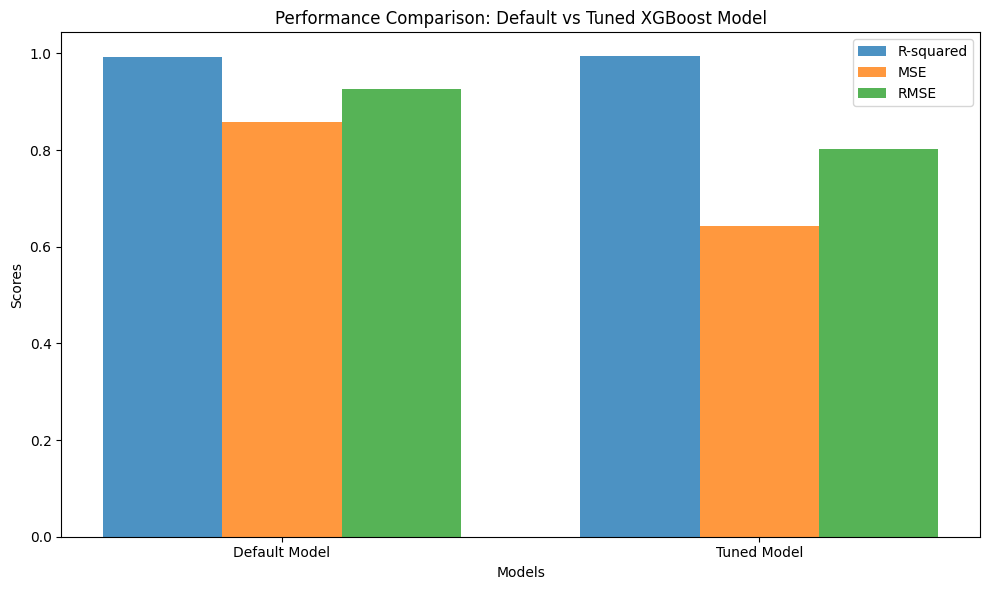

In [ ]:
models = ['Default Model', 'Tuned Model']
r2_scores = [xgb_default_score, xgb_tuned_score]
mse_scores = [xgb_default_mse, xgb_tuned_mse]
rmse_scores = [xgb_rmse, xgb_tuned_rmse]

# Create a bar chart for comparison
x = np.arange(len(models))  # Label locations
width = 0.25  # Width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# R-squared scores
ax.bar(x - width, r2_scores, width, label='R-squared', alpha=0.8)

# MSE scores
ax.bar(x, mse_scores, width, label='MSE', alpha=0.8)

# RMSE scores
ax.bar(x + width, rmse_scores, width, label='RMSE', alpha=0.8)

# Add labels, title, and legend
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Performance Comparison: Default vs Tuned XGBoost Model')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

# **Conclusion and Discussion**

There were a key takeaways that stood out throughout this exercise


**From EDA and Preprocessing:**

1.   The lack of data representation across the counties. The data was concentrated in few months and boroughs of NYC. We had to adjust our analysis through out so it makes sense given the data limitations.
2.   Average speed is surprisingly low in NYC, even lower than what I had anticipated.
3. There is no linear relationship between the Trip Duration and Total Cost of trip. Average cost of medium ranged trips 2-3 hours is higher than that of longer duration trips.
4. from the limited number of boroughs in our dataset, EWR had the highest tip price.
5. There is a dip in number of rides available at noon and midnight.

**From Model Implementation:**


1.   Due to our strict pre-processing and rich feature generation, our models are fitting really well.
2.   PCA made our performance worse (rare but happens)
3. Lasso regularization didn't perform well in our case but due to low alpha Ridge regularization performed almost as well as baseline.
4.  XGBoost took the longest to run such that we had to turn to GPU acceleration. However, it yielded great performance and hyperparameter tuning showed improvement in accuracy by decreased RMSE values.

**Modeling Implications:**

Our dataset needs to be more rich, showing data from throughout the year and more data points from more boroughs. Maybe then it will be more diverse and model performance will be more realistic and generalizable.

**Future Work:**

There is great potential in prototyping and learning how companies like Uber and Lyft suggest fares based on how busy it is and weather. There is also potential to train Neural Networks that can judge if a trip price was fair for both the driver and customer.


